<a href="https://colab.research.google.com/github/Voidmort/Study-Notes-TensorFlow/blob/master/TensorFlow_4_rerror.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: TensorFlow 4
date: 2019-01-03 15:10:00
tags: Tensorflow
categories: Tensorflow
---

# 合成特征和离群值

首先，加载加利福尼亚州的住房数据

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3817,-117.9,33.8,11.0,2880.0,745.0,1806.0,722.0,3.8,171.1
1194,-117.1,32.8,22.0,2623.0,732.0,1283.0,718.0,2.2,127.1
1766,-117.2,32.8,37.0,1189.0,377.0,645.0,377.0,2.5,216.7
4342,-118.0,34.1,34.0,1077.0,257.0,478.0,199.0,2.6,252.8
828,-117.1,32.8,14.0,2523.0,545.0,1297.0,525.0,2.4,138.1
...,...,...,...,...,...,...,...,...,...
14572,-122.2,37.8,46.0,1827.0,307.0,881.0,302.0,4.7,164.3
280,-116.7,34.9,14.0,4527.0,875.0,1640.0,590.0,2.9,81.7
1211,-117.1,32.7,43.0,2160.0,504.0,1221.0,452.0,2.5,140.6
6704,-118.3,34.0,31.0,700.0,299.0,1272.0,298.0,2.2,128.1


设置输入函数：

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    """一个线性回归的训练模型
    参数：
        learning_rate: 学习速率 float
        steps: 训练总次数 int
        batch_size: 批处理大小 非0 int
        input_feature: 一个' string '，指定一个来自' california_housing_dataframe '的列用作输入特性。          
    """
    periods = 10  # 周期
    steps_per_period = steps / periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label]
    
    # 创建 feature columns
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # 创建 input feature
    training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=True)
    
    # 创建 一个线性回归对象
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    # 设置回归线的状态
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    # 训练模型，但是在循环中这样做，这样我们就可以周期性地评估
    # 损失指标
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = [] 
    for period in range(0, periods):
        # 训练模型，从之前的状态开始
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # 计算预测值
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        # 计算损失
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        print("   period %02d : %0.2f" % (period, root_mean_squared_error))
        # 添加loss 到list
        root_mean_squared_errors.append(root_mean_squared_error)
        # 纪录权重和偏差
        y_extents = np.array([0, sample[my_label].max()])

        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[my_feature].max()),
                               sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    
    print("Model training finished.")
    
    # 输出一个周期内损失指标的图表。
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # 输出带有校准数据的表
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)   

Training model...
RMSE (on training data):
   period 00 : 214.22
   period 01 : 192.79
   period 02 : 174.15
   period 03 : 161.12


KeyboardInterrupt: ignored

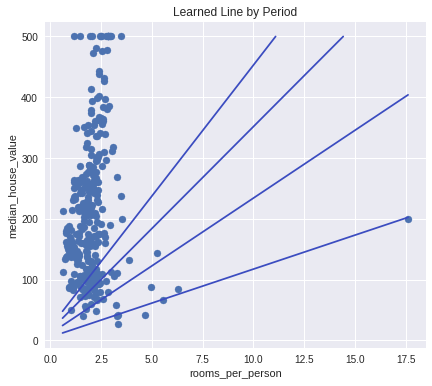

In [0]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

print(calibration_data)

TypeError: ignored

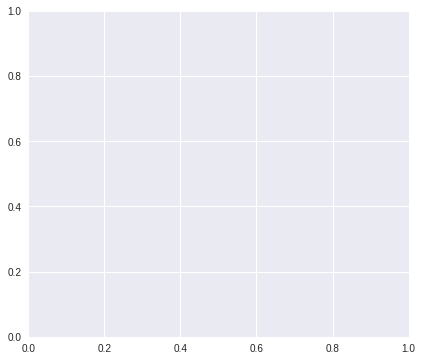

In [0]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])